Reference: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

# Imports

In [3]:
import sys
from typing import List
import time

import torch
from torch import nn
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split, Subset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import heapq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Change system path to base directory.
sys.path.append("..")
from preprocessing.preprocessor import Preprocessor
from datasets.fake_news_detection import FakeNewsDetectionDataset

# Manual set seed for reproducible results
torch.manual_seed(1)

## Read & process dataset

In [4]:
# Control which linguistic preprocessing steps should run.
preprocessor = Preprocessor(perform_case_folding=True,
                            remove_stop_words=False,
                            remove_punctuation=True,
                            perform_lemmatization=False,
                            perform_stemming=False)

# Generate training and test datasets.
training_dataset = FakeNewsDetectionDataset("../raw_data/fulltrain.csv",
        transform=preprocessor.process, target_transform=lambda x: int(x) - 1)
test_dataset = FakeNewsDetectionDataset("../raw_data/balancedtest.csv",
        transform=preprocessor.process, target_transform=lambda x: int(x) - 1)

## Prepare data processing pipelines, generate data batch and iterator

In [5]:
def yield_tokens(dataset: FakeNewsDetectionDataset) -> List[str]:
    for i in range(len(dataset)):
        sentence, _ = dataset[i]
        yield sentence

vocab = build_vocab_from_iterator(yield_tokens(training_dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
text_pipeline = lambda x: vocab(x)

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for text, label in batch:
        label_list.append(label)
        processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

## Training

### Model class

In [6]:
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
        self.fc = nn.Linear(embed_dim, 4)

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

### Define train/eval functions, split training data

In [7]:
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize).to(device)

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    tp, fp, fn = [0] * 4, [0] * 4, [0] * 4

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets).argmax(1)
            total_acc += (predicted_label == label).sum().item()
            total_count += label.size(0)

            for lab in range(4):
                tp[lab] += torch.mul(predicted_label == lab, label == lab).sum().item()
                fp[lab] += torch.mul(predicted_label == lab, label != lab).sum().item()
                fn[lab] += torch.mul(predicted_label != lab, label == lab).sum().item()

    f1s = [tp[lab] / (tp[lab] + 0.5 * (fp[lab] + fn[lab])) for lab in range(4)]
    return total_acc/total_count, f1s[0], f1s[1], f1s[2], f1s[3], sum(f1s)/4

# Hyperparameters
EPOCHS = 10 # epoch
LR = 0.001  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
num_train: int = int(len(training_dataset) * 0.95)
split_train_: Subset[FakeNewsDetectionDataset]
split_valid_: Subset[FakeNewsDetectionDataset]
split_train_, split_valid_ = random_split(training_dataset, [num_train, len(training_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

### Training Loop

In [6]:
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val, f1_0, f1_1, f1_2, f1_3, f1_macro = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid accuracy {:8.3f} '
          '| f1 of class 0 {:8.3f} | f1 of class 1 {:8.3f} | f1 of class 2 {:8.3f} '
          '| f1 of class 3 {:8.3f} | macro f1 {:8.3f}'.format(epoch,
                                              time.time() - epoch_start_time,
                                              accu_val, f1_0, f1_1, f1_2, f1_3, f1_macro))
    print('-' * 59)

In [ ]:
# Save trained model
torch.save(model.state_dict(), '../trained_models/SNNModel-%sepoch.pt' % EPOCHS)

In [8]:
# Load saved model to skip training
model.load_state_dict(torch.load('../trained_models/SNNModel-%sepoch.pt' % EPOCHS, map_location=device))

<All keys matched successfully>

### Evaluating on test set

In [9]:
print('Checking the results of test dataset.')
accu_test, f1_0_test, f1_1_test, f1_2_test, f1_3_test, f1_macro_test = evaluate(test_dataloader)
print('test accuracy {:8.3f} | test f1 of class 0 {:8.3f} | test f1 of class 1 {:8.3f} '
      '| test f1 of class 2 {:8.3f} | test f1 of class 3 {:8.3f} | test macro f1 {:8.3f}'.format(accu_test, f1_0_test, f1_1_test, f1_2_test, f1_3_test, f1_macro_test))

Checking the results of test dataset.
test accuracy    0.702 | test f1 of class 0    0.804 | test f1 of class 1    0.567 | test f1 of class 2    0.579 | test f1 of class 3    0.830 | test macro f1    0.695


### Checking relationships between labels for documents

In [43]:
CATEGORIES = { 1: 'Satire', 2: 'Hoax', 3: 'Propaganda', 4: 'Reliable news' }

reliable, hoax, satire, propaganda = [], [], [], []

all_documents_dataloader = DataLoader(training_dataset, batch_size=1,
                             shuffle=True, collate_fn=collate_batch)

with torch.no_grad():
    for idx, (label, text, offsets) in enumerate(all_documents_dataloader):
        output = model(text, offsets)
        arr = output.numpy()[0]
        reliable.append(arr[3])
        hoax.append(arr[1])
        satire.append(arr[0])
        propaganda.append(arr[2])

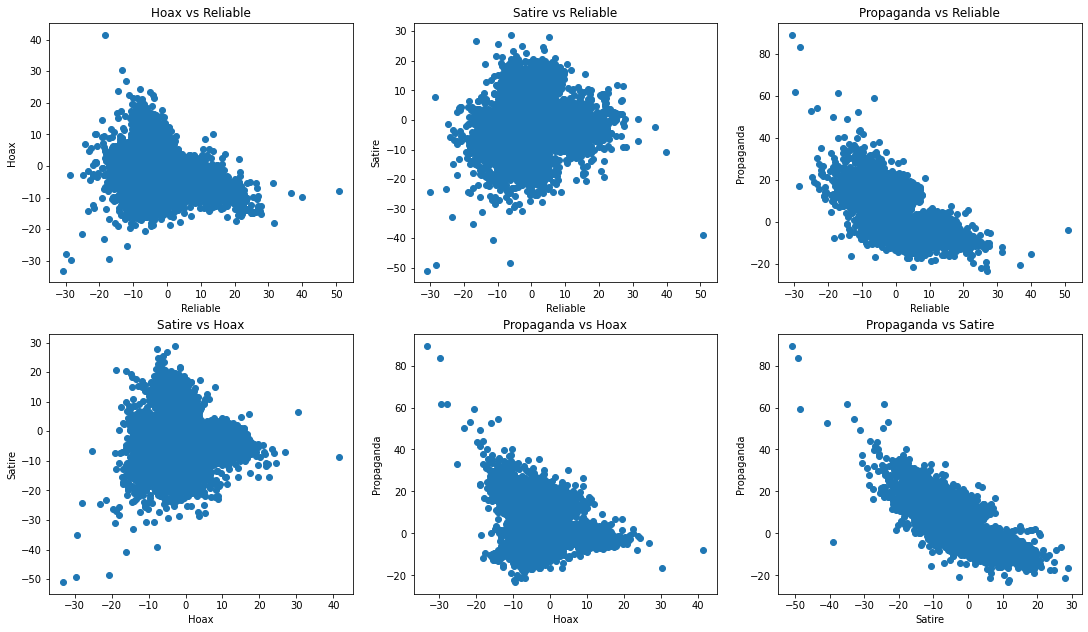

In [21]:
documents_fig, documents_axs = plt.subplots(2, 3)
documents_axs[0, 0].scatter(reliable, hoax)
documents_axs[0, 0].set(xlabel='Reliable', ylabel='Hoax')
documents_axs[0, 0].set_title('Hoax vs Reliable')

documents_axs[0, 1].scatter(reliable, satire)
documents_axs[0, 1].set(xlabel='Reliable', ylabel='Satire')
documents_axs[0, 1].set_title('Satire vs Reliable')

documents_axs[0, 2].scatter(reliable, propaganda)
documents_axs[0, 2].set(xlabel='Reliable', ylabel='Propaganda')
documents_axs[0, 2].set_title('Propaganda vs Reliable')

documents_axs[1, 0].scatter(hoax, satire)
documents_axs[1, 0].set(xlabel='Hoax', ylabel='Satire')
documents_axs[1, 0].set_title('Satire vs Hoax')

documents_axs[1, 1].scatter(hoax, propaganda)
documents_axs[1, 1].set(xlabel='Hoax', ylabel='Propaganda')
documents_axs[1, 1].set_title('Propaganda vs Hoax')

documents_axs[1, 2].scatter(satire, propaganda)
documents_axs[1, 2].set(xlabel='Satire', ylabel='Propaganda')
documents_axs[1, 2].set_title('Propaganda vs Satire')
documents_fig.set_size_inches(18.5, 10.5)
documents_fig.savefig('documents_rs.png', dpi=100)

plt.show()

### Checking relationships between labels for words

In [10]:
words = vocab.get_itos()

def collate_word(word):
    text_list, offsets = [], [0]
    processed_text = torch.tensor(text_pipeline(word), dtype=torch.int64)
    text_list.append(processed_text)
    offsets.append(processed_text.size(0))
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return text_list.to(device), offsets.to(device)

reliable, hoax, satire, propaganda = [], [], [], []

with torch.no_grad():
    for word in words:
        text, offsets = collate_word(list(word))
        output = model(text, offsets)
        arr = output.numpy()[0]
        reliable.append(arr[3])
        hoax.append(arr[1])
        satire.append(arr[0])
        propaganda.append(arr[2])

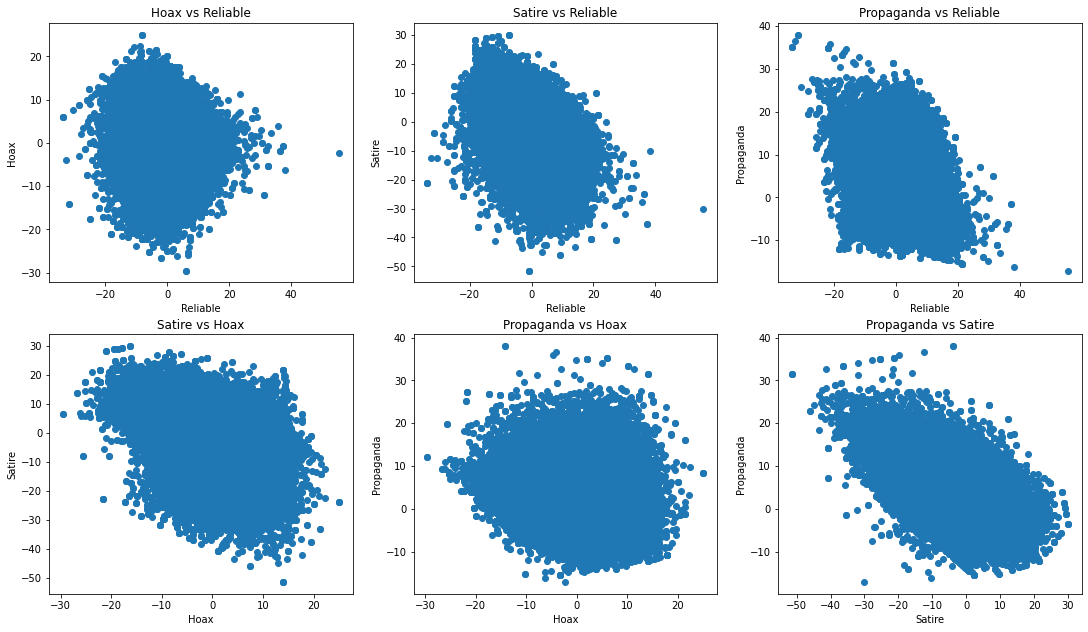

In [45]:
documents_fig, documents_axs = plt.subplots(2, 3)
documents_axs[0, 0].scatter(reliable, hoax)
documents_axs[0, 0].set(xlabel='Reliable', ylabel='Hoax')
documents_axs[0, 0].set_title('Hoax vs Reliable')

documents_axs[0, 1].scatter(reliable, satire)
documents_axs[0, 1].set(xlabel='Reliable', ylabel='Satire')
documents_axs[0, 1].set_title('Satire vs Reliable')

documents_axs[0, 2].scatter(reliable, propaganda)
documents_axs[0, 2].set(xlabel='Reliable', ylabel='Propaganda')
documents_axs[0, 2].set_title('Propaganda vs Reliable')

documents_axs[1, 0].scatter(hoax, satire)
documents_axs[1, 0].set(xlabel='Hoax', ylabel='Satire')
documents_axs[1, 0].set_title('Satire vs Hoax')

documents_axs[1, 1].scatter(hoax, propaganda)
documents_axs[1, 1].set(xlabel='Hoax', ylabel='Propaganda')
documents_axs[1, 1].set_title('Propaganda vs Hoax')

documents_axs[1, 2].scatter(satire, propaganda)
documents_axs[1, 2].set(xlabel='Satire', ylabel='Propaganda')
documents_axs[1, 2].set_title('Propaganda vs Satire')
documents_fig.set_size_inches(18.5, 10.5)
documents_fig.savefig('words_rs.png', dpi=100)

plt.show()

### Get word association graph of words that appear most in each category

In [11]:
document_frequencies = pd.read_csv('../raw_data/document_frequencies.csv')

reliable_filtered = document_frequencies[document_frequencies['4'] > (9995 * 0.1)]
most_reliable_words = reliable_filtered.nlargest(10, ['reliable'])[['word', 'reliable']]

hoax_filtered = document_frequencies[document_frequencies['2'] > (9995 * 0.1)]
most_hoax_words = hoax_filtered.nlargest(10, ['hoax'])[['word', 'hoax']]

satire_filtered = document_frequencies[document_frequencies['1'] > (9995 * 0.1)]
most_satire_words = satire_filtered.nlargest(10, ['satire'])[['word', 'satire']]

propaganda_filtered = document_frequencies[document_frequencies['3'] > (9995 * 0.1)]
most_propaganda_words = propaganda_filtered.nlargest(10, ['propaganda'])[['word', 'propaganda']]

### Generate word graph

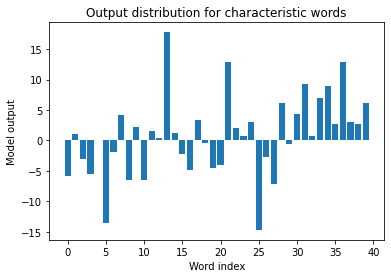

In [13]:
concat = np.concatenate([most_reliable_words.to_numpy(), most_hoax_words.to_numpy(),
                        most_satire_words.to_numpy(), most_propaganda_words.to_numpy()])

word, data, res = [], [], []

with torch.no_grad():
    for i in range(0, len(concat)):
        word.append(concat[i][0])
        data.append(concat[i][1])
        text, offsets = collate_word(list(concat[i][0]))
        output = model(text, offsets)
        arr = output.numpy()[0]
        if i < 10:
            res.append(arr[3])
        elif i < 20:
            res.append(arr[1])
        elif i < 30:
            res.append(arr[0])
        else:
            res.append(arr[2])

plt.bar(range(0, 40), res)
plt.title('Output distribution for characteristic words')
plt.xlabel('Word index')
plt.ylabel('Model output')
plt.savefig('word_dist.png', dpi=100)
plt.show()